# Figure 3

Still a draft. Mainly need to figure out significance ...

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import xarray as xr
import numpy as np
import datetime as dt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from scipy import stats
from dask.distributed import Client

In [2]:
# OOD
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=4,memory="31GB")
client = Client(cluster)

In [3]:
client

Client Scheduler: tcp://10.0.96.1:40021 Dashboard: http://10.0.96.1:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
cluster

In [5]:
HardDisk = '/g/data/v45/amh157/OCCIPUT/'
EnsembleDir = 'processed_eke/'

In [6]:
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=1.0)

In [7]:
def pearsoncor(y1, y2):
    ## Looking for lagged correlations between two timeseries
    ## Assumes y1 is leading
    ## Avoid end effects by using only first 2/3rds of timeseries
    n = len(y1)
    nc = int(n/3.5)
    
    # De-mean both timeseries
    y1t = y1-np.mean(y1)
    y2t = y2-np.mean(y2)    

    cor = np.zeros(nc)
    sig = np.zeros(nc)
    for j in np.arange(0, nc):
        x1t = np.roll(y1t, j)[j:]#y1t[:-j]
        x2t = y2t[j:]
        cor[j], sig[j] = stats.pearsonr(x1t, x2t)
    return cor, sig

# Load EKE Climatology File

In [8]:
EKEDir = 'processed_eke/'
climfilename = HardDisk+EKEDir+'eke_climatology.nc'
eke_month = xr.open_dataset(climfilename).EKE.mean('month').fillna(0)

## Compute variance ratios from saved results

In [9]:
def PlotThisBox(desc, lon1, lon2, lat1, lat2, ax_map, ax_ts, ax_lag, col):

    ## Other things to set
    nfiles = 50
    nn=0
    start = dt.datetime(1980,1,1) ## start time for plotting
    end = dt.datetime(2014,12,31)

    ## Add lines to show our region of interest on the map
    ax_map.plot([lon1, lon2, lon2, lon1, lon1],[lat1,lat1,lat2,lat2,lat1],
            color=col,linewidth=2,transform=ccrs.PlateCarree())

    ## plot EKE
    eke_results = []
    for ii in range(1,nfiles+1):
        nn+=1
        i00 = '%03d' % ii
        Member = 'e'+i00
        ekefilename = HardDisk+EKEDir+'/eke_'+i00+'_????.nc'
        
        eke = xr.open_mfdataset(ekefilename).EKE
    
        eke = eke.sel(lon=slice(lon1,lon2)).sel(lat=slice(lat1,lat2)).mean('lon').mean('lat')
        eke = eke.rolling(time=12,center=True).mean().load()
        eke.plot(ax=ax_ts,color=[0.5, 0.5, 0.5],linewidth=0.5)
    
        result = {'ii': ii,'eke': eke}
        eke_results.append(result)
    
        if ii==1:
            eke_sum = eke
        else:
            eke_sum = eke_sum + eke
        #print(ekefilename)
                        
    eke_sum = eke_sum.load()/nn
    eke_sum.plot(ax=ax_ts,color=col,linewidth=2)
    ax_ts.set_xlabel('')
    ax_ts.set_ylabel('EKE (m$^2$/s$^2$)',color=col)
    #ax_eke.set_ylim(ymax=0.013)
    ax_ts.tick_params('y',labelcolor=col)
    ax_ts.set_xlim([start,end])

    # Compute variance ratios from saved results
    for result in eke_results:
        ii = result['ii']
        eke = result['eke']
    
        if ii==1:
            eke_var = (eke - eke_sum)**2
        else:
            eke_var = eke_var + (eke - eke_sum)**2
        
    eke_var = eke_var.load()/nn
    sigma2 = np.var(eke_sum)  
    epsilon2 = eke_var.mean('time')
    ratio = (epsilon2/(epsilon2+sigma2))
    ax_ts.set_title(desc+': $R_i$ = %0.2f'%ratio.values)
    print(desc+' R_i = %0.2f'%ratio.values)

    ## Axes to plot the wind
    ax_tau=ax_ts.twinx()
    taufilename = HardDisk+'processed_tau/'+'tau_????.nc'
    tau = xr.open_mfdataset(taufilename).tau
    
    tau = tau.sel(lon=slice(lon1,lon2)).sel(lat=slice(lat1,lat2)).mean('lon').mean('lat')
    tau = tau.rolling(time=12,center=True).mean().load()
    tau.plot(ax=ax_tau,color='k',linestyle='-',linewidth=1)
    #ax_tau.set_ylim(ymin=0.08)
    ax_tau.set_ylabel('Wind Stress (N/m$^2$)')
    ax_tau.set_xlim([start,end])

    ## Axes to plot lagged correlation
    taup = tau[6:-6] - tau.mean()       
    ekep = eke_sum[6:-6] - eke_sum.mean()
    coef, signif = pearsoncor(taup,ekep)
    lag = coef.argmax()
    ax_lag.plot(coef,linewidth=2,color=col,label=desc[4:-1])
    print('Correlations: %d months, %0.2f, %0.2f'%(lag, coef[lag], signif[lag]))
    ax_lag.plot(lag,coef[lag],'.',color='k')

## And now plot

(b) Southeast Indian Ocean  R_i = 0.51
Correlations: 7 months, 0.64, 0.00
(d) Southwest Pacific Ocean R_i = 0.56
Correlations: 15 months, 0.54, 0.00
(e) South Atlantic Ocean R_i = 0.65
Correlations: 13 months, 0.09, 0.06


<timed exec>:37: UserWarning: Legend does not support 'c' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
<timed exec>:37: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
<timed exec>:37: UserWarning: Legend does not support 'darkorange' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


CPU times: user 4min 48s, sys: 23.2 s, total: 5min 11s
Wall time: 8min 13s


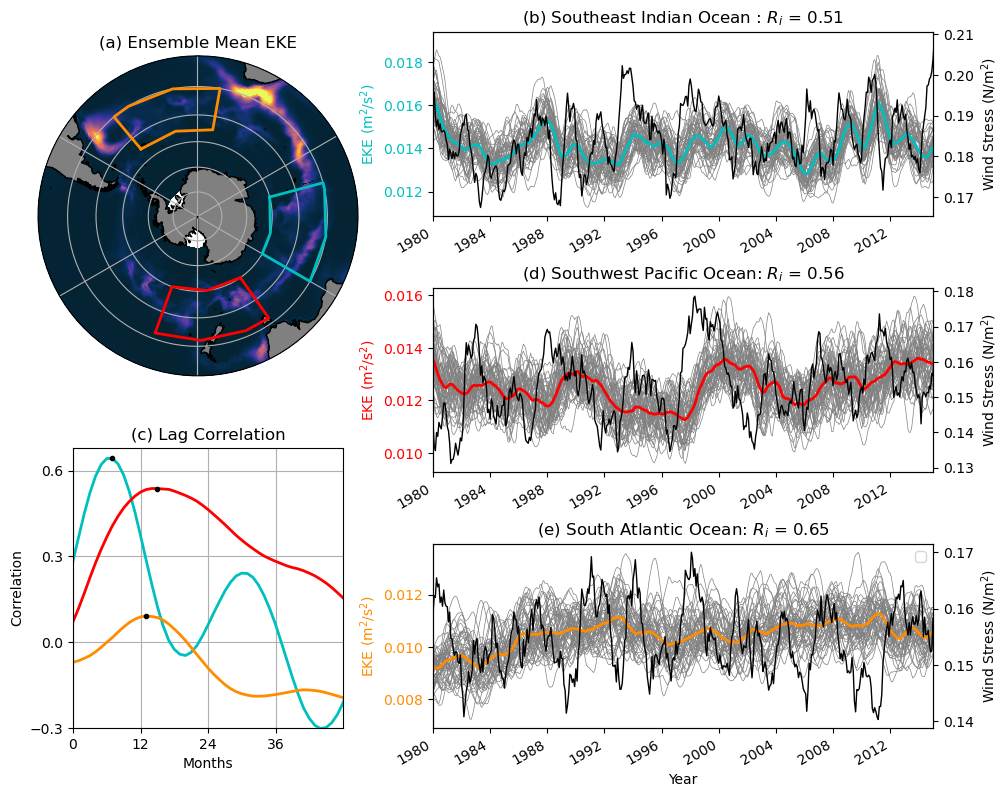

In [11]:
%%time
plt.figure(figsize=(10, 8))

ax_map = plt.axes([0.02, 0.52, 0.35, 0.4],projection=ccrs.SouthPolarStereo())
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax_map.set_extent([-287, 73, -80, -30], crs=ccrs.PlateCarree())
ax_map.set_boundary(circle, transform=ax_map.transAxes)
ax_map.add_feature(land_50m)
ax_map.gridlines()
p1 = eke_month.plot(ax=ax_map,cmap=cm.cm.thermal,vmax=0.2,add_colorbar=False,transform=ccrs.PlateCarree())
ax_map.set_title('(a) Ensemble Mean EKE')

ax_lag = plt.axes([0.07, 0.08, 0.27, 0.35])
ax_ts1 = plt.axes([0.43, 0.72, 0.5, 0.23])
ax_ts2 = plt.axes([0.43, 0.4, 0.5, 0.23])
ax_ts3 = plt.axes([0.43, 0.08, 0.5, 0.23])

PlotThisBox('(b) Southeast Indian Ocean ', -285, -240, -60, -40, ax_map, ax_ts1, ax_lag,'c')
PlotThisBox('(d) Southwest Pacific Ocean', -215, -160, -60, -42, ax_map, ax_ts2, ax_lag,'r')
PlotThisBox('(e) South Atlantic Ocean', -40, 10, -55, -40, ax_map, ax_ts3, ax_lag,'darkorange')

ax_ts3.set_xlabel('Year')

ax_lag.set_xlim([0,48])
ax_lag.set_ylim([-0.3,0.68])
ax_lag.set_xticks([0, 12, 24, 36])
ax_lag.set_yticks([-0.3, 0.0, 0.3, 0.6])
ax_lag.set_title('(c) Lag Correlation')
ax_lag.set_xlabel('Months')
ax_lag.set_ylabel('Correlation')
ax_lag.grid()
#plt.legend(['c','r','darkorange'],['Southeast Indian','Southwest Pacific','South Atlantic'])

plt.savefig('/g/data/x77/amh157/OCCIPUT-analysis/paper/figures/Figure3.png',dpi=200)